In [1]:
#installing dependencies
!pip install tensorflow tensorflow-gpu opencv-python matplotlib


In [1]:
#import dependencies 
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#import tensorflow dependencies- functional api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


In [56]:
#set gpu growth
#avoid out of memory errors by setting gpu memory growth that is how much vram can tf use
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [5]:
gpus

[]

In [3]:
#setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [41]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [20]:
#uncompress tgz for dataset
!tar -xf lfw.tgz

In [21]:
#move lfw imgs to data/neg
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [42]:
#Import uuid library to generate unique img names
import uuid

In [27]:
#get pos and anchor data from webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    cv2.imshow('Image collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

In [4]:
#get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpeg').take(96)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpeg').take(96)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpeg').take(96)

In [5]:
#preprocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_bmp(byte_img, channels=3)
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    return img
    

In [6]:
#create labelled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [7]:
#joining preprocessed imgs to labels
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [8]:
#apply preprocess_twin on data and build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [9]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [10]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [11]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [129]:
#build an embedded layer
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    #first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding ='same')(c1)
    
    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding ='same')(c2)
    
    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding ='same')(c3)
    
    #final embedded block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [130]:
embedding = make_embedding()

In [131]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

In [12]:
#Siamese distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [133]:
#bringing everything together and making the siamese model
def make_siamese_model():
    
    #anchor i/p
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #validation i/p
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification layer
    classifier= Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image], outputs=classifier, name= 'SiameseNetwork')

In [134]:
siamese_model = make_siamese_model()

In [135]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [136]:
#loss function

binary_cross_loss = tf.losses.BinaryCrossentropy()

In [137]:
#optimizer

opt = tf.keras.optimizers.Adam(1e-4)

In [138]:
#establish checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [139]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        #get anchor and positive/negative image
        X = batch[:2]
        #get label
        y = batch[2]
        
        #forward pass
        yhat = siamese_model(X, training=True)
        #calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [140]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    

In [141]:
EPOCHS = 50

In [142]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
9/9 [==============================] - 5s 176ms/step

 Epoch 2/50
9/9 [==============================] - 1s 151ms/step

 Epoch 3/50
9/9 [==============================] - 1s 150ms/step

 Epoch 4/50
9/9 [==============================] - 1s 150ms/step

 Epoch 5/50
9/9 [==============================] - 1s 151ms/step

 Epoch 6/50
9/9 [==============================] - 1s 151ms/step

 Epoch 7/50
9/9 [==============================] - 1s 150ms/step

 Epoch 8/50
9/9 [==============================] - 1s 151ms/step

 Epoch 9/50
9/9 [==============================] - 1s 151ms/step

 Epoch 10/50
9/9 [==============================] - 1s 151ms/step

 Epoch 11/50
9/9 [==============================] - 1s 151ms/step

 Epoch 12/50
9/9 [==============================] - 1s 151ms/step

 Epoch 13/50
9/9 [==============================] 

In [143]:
#evaluate model

#import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [144]:
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [145]:
#make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat


1/1 [==============================] - 0s 97ms/step


array([[1.1475850e-06],
       [1.0000000e+00],
       [9.9983847e-01],
       [1.5937768e-06],
       [1.0000000e+00],
       [1.1198146e-07],
       [1.1382459e-05],
       [9.5720871e-09],
       [1.0000000e+00],
       [9.9999511e-01],
       [8.3164775e-07],
       [1.5937768e-06],
       [9.9967277e-01],
       [1.0000000e+00],
       [9.9999082e-01],
       [1.4505464e-08]], dtype=float32)

In [146]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]

In [147]:
#using metrics
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()



1.0

In [148]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()


1.0

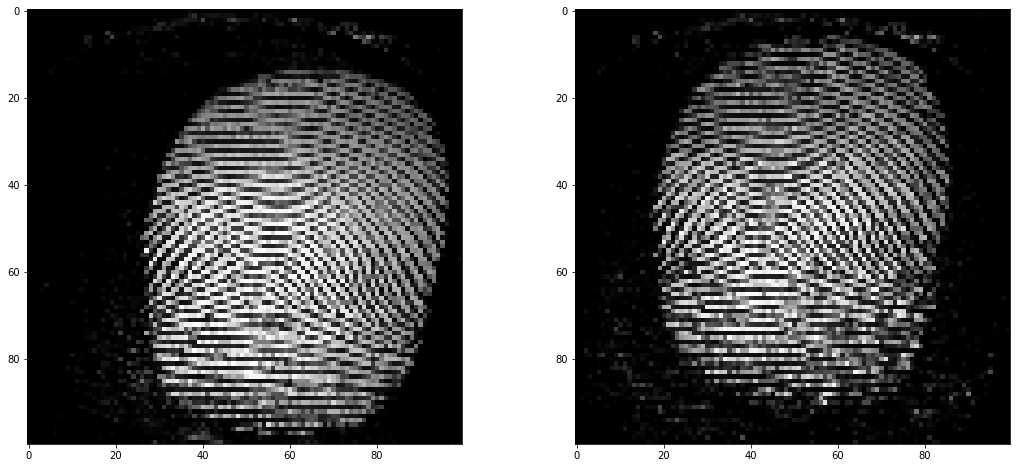

In [149]:
#visualise results
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

In [150]:
#save the model
#save the model weights
siamese_model.save('fpsiamesemodel.h5')


In [13]:
#reload model
model = tf.keras.models.load_model('fpsiamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [20]:
new_test_input, new_test_val, new_y_true = test_data.as_numpy_iterator().next()

In [21]:
test_predict=model.predict([new_test_input, new_test_val])


1/1 [==============================] - 0s 18ms/step


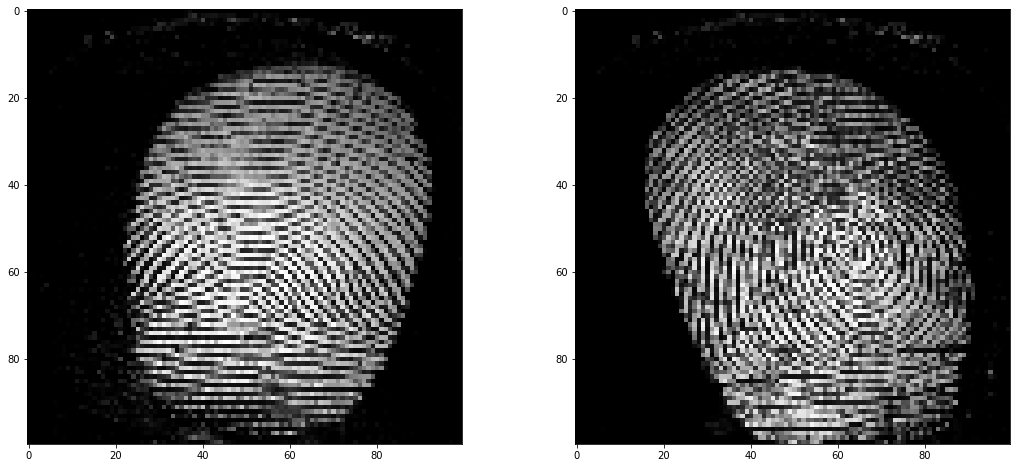

In [22]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(new_test_input[7])
plt.subplot(1,2,2)
plt.imshow(new_test_val[7])
plt.show()

In [23]:
new_y_pred = [1 if prediction > 0.5 else 0 for prediction in test_predict]
new_y_pred

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]

In [24]:
import sklearn.metrics

#confusion matrix
conf_mat = sklearn.metrics.confusion_matrix(new_y_true, new_y_pred)
print('confusion matrix:')
print(conf_mat)
print()

#accuracy
accuracy = sklearn.metrics.accuracy_score(new_y_true, new_y_pred) 
print('accuracy:', accuracy)
print()

#precision
precision = sklearn.metrics.precision_score(new_y_true, new_y_pred)
print('precision:', precision)
print()

#recall
recall = sklearn.metrics.recall_score(new_y_true, new_y_pred)
print('recall:', recall)

confusion matrix:
[[10  0]
 [ 0  6]]

accuracy: 1.0

precision: 1.0

recall: 1.0
